In [23]:
using Flux
using HDF5
using Random
using Flux: flatten
using Flux.Data: DataLoader
using ProgressBars
using Flux: update!
using Plots
using LinearAlgebra
default(fontfamily="Computer Modern", framestyle=:box)

In [5]:
using BSON

In [119]:
include("lines_to_crosstrack.jl")

get_state (generic function with 2 methods)

# Load in the San Martin Data

In [18]:
# Load in the data
data_fn = "/scratch/smkatz/class/CS231A/E16Data/downsampled_64_mb.h5"
imgs = Float32.(h5read(data_fn, "X_train"))
labels = Float32.(h5read(data_fn, "y_train"))

# Shuffle
Random.seed!(32)
shuffle_inds = randperm(size(imgs, 3))
imgs = imgs[:, :, shuffle_inds]
labels = labels[:, shuffle_inds]

# Split into train and valid
n_train = 9500
X_train = imgs[:, :, 1:n_train]
X_valid = imgs[:, :, n_train+1:end]
y_train = labels[1:4, 1:n_train]
y_valid = labels[1:4, n_train+1:end]
labels_train = labels[:, 1:n_train]
labels_valid = labels[:, n_train+1:end]

# Add channel dimension
X_train = reshape(X_train, size(X_train, 1), size(X_train, 2), 1, size(X_train, 3))
X_valid = reshape(X_valid, size(X_valid, 1), size(X_valid, 2), 1, size(X_valid, 3));

# Load in the Model

In [7]:
model = BSON.load("../../initial_model.bson")[:model];

# Get Predictions on Validation Set

In [9]:
preds_valid = model(X_valid);

In [62]:
nvalid = size(X_valid, 4)
crosstrack_preds_r = zeros(nvalid)
heading_preds_r = zeros(nvalid)

crosstrack_preds_l = zeros(nvalid)
heading_preds_l = zeros(nvalid)

zs = ones(nvalid)

for i = 1:nvalid
    cr, hr = get_state(preds_valid[1, i], preds_valid[2, i], K0, ground_plane_sm, u1_sm, c1_sm, hw_sm, right=true)
    cl, hl = get_state(preds_valid[3, i], preds_valid[4, i], K0, ground_plane_sm, u1_sm, c1_sm, hw_sm, right=false)
    crosstrack_preds_r[i] = cr
    heading_preds_r[i] = hr
    crosstrack_preds_l[i] = cl
    heading_preds_l[i] = hl

    if abs(cr - cl) > 2 || (hr - hl) > 4
        zs[i] = 0
    end
end

In [142]:
include("lines_to_crosstrack.jl")

get_state (generic function with 2 methods)

In [143]:
nvalid = size(X_valid, 4)
crosstrack_preds_r = zeros(nvalid)
heading_preds_r = zeros(nvalid)

crosstrack_preds_l = zeros(nvalid)
heading_preds_l = zeros(nvalid)

zs = ones(nvalid)

for i = 1:nvalid
    cr, hr = get_state(labels_valid[1, i], labels_valid[2, i], K0, ground_plane_sm, u1_sm, c1_sm, hw_sm, right=false)
    cl, hl = get_state(labels_valid[3, i], labels_valid[4, i], K0, ground_plane_sm, u1_sm, c1_sm, hw_sm, right=true)
    crosstrack_preds_r[i] = cr
    heading_preds_r[i] = hr
    crosstrack_preds_l[i] = cl
    heading_preds_l[i] = hl

    if abs(cr - cl) > 2 || (hr - hl) > 4
        zs[i] = 0
    end
end

In [144]:
true_crosstracks = labels_valid[5, :]
true_headings = labels_valid[6, :];

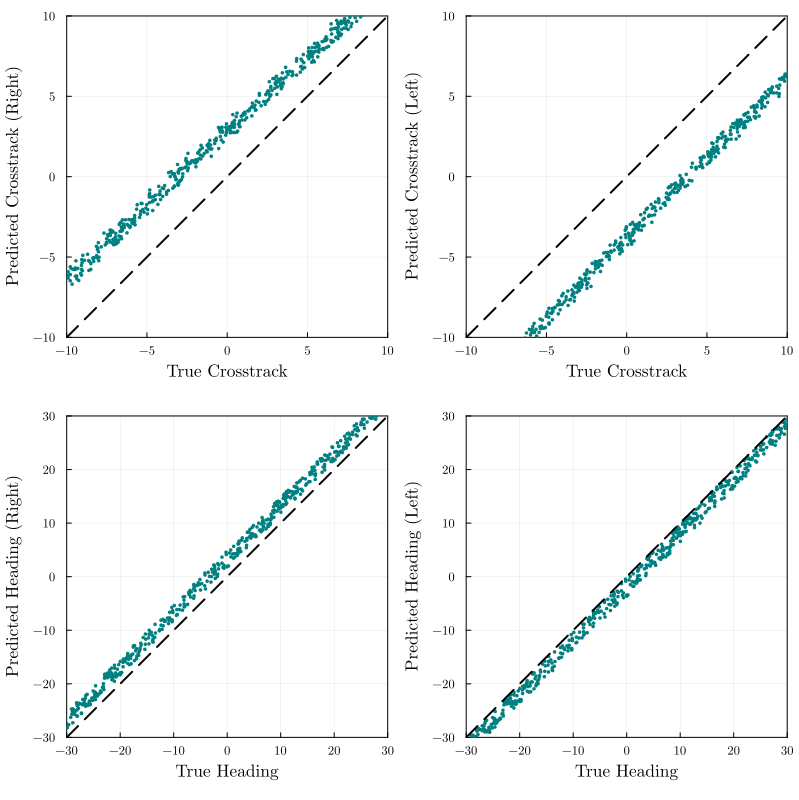

In [145]:
p1 = scatter(true_crosstracks, crosstrack_preds_r, legend=false, xlims=(-10.0, 10.0), ylims=(-10.0, 10.0),
    xlabel="True Crosstrack", ylabel="Predicted Crosstrack (Right)", markercolor=:teal,
    markerstrokecolor=:teal, markersize=2)
plot!(p1, [-10.0, 10.0], [-10.0, 10.0], color=:black, linestyle=:dash, lw=2, aspect_ratio=:equal)

p2 = scatter(true_crosstracks, crosstrack_preds_l, legend=false, xlims=(-10.0, 10.0), ylims=(-10.0, 10.0),
    xlabel="True Crosstrack", ylabel="Predicted Crosstrack (Left)", markercolor=:teal,
    markerstrokecolor=:teal, markersize=2)
plot!(p2, [-10.0, 10.0], [-10.0, 10.0], color=:black, linestyle=:dash, lw=2, aspect_ratio=:equal)

p3 = scatter(true_headings, heading_preds_r, legend=false, xlims=(-30.0, 30.0), ylims=(-30.0, 30.0),
    xlabel="True Heading", ylabel="Predicted Heading (Right)", markercolor=:teal,
    markerstrokecolor=:teal, markersize=2)
plot!(p3, [-30.0, 30.0], [-30.0, 30.0], color=:black, linestyle=:dash, lw=2, aspect_ratio=:equal)

p4 = scatter(true_headings, heading_preds_l, legend=false, xlims=(-30.0, 30.0), ylims=(-30.0, 30.0),
    xlabel="True Heading", ylabel="Predicted Heading (Left)", markercolor=:teal,
    markerstrokecolor=:teal, markersize=2)
plot!(p4, [-30.0, 30.0], [-30.0, 30.0], color=:black, linestyle=:dash, lw=2, aspect_ratio=:equal)

p = plot(p1, p2, p3, p4, layout=(2,2), size=(800,800))

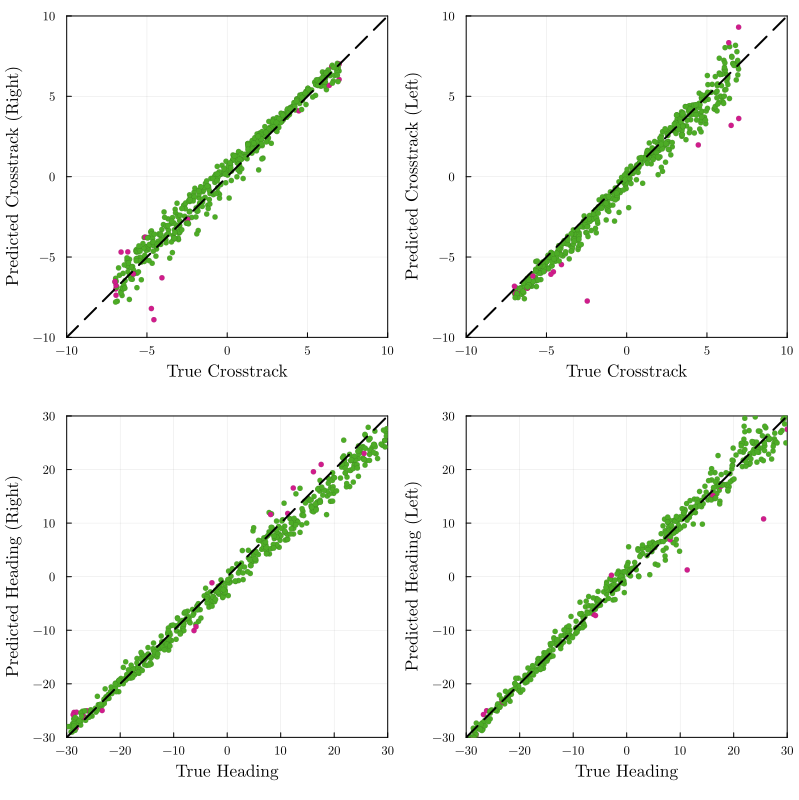

In [65]:
p1 = scatter(true_crosstracks, crosstrack_preds_r, legend=false, xlims=(-10.0, 10.0), ylims=(-10.0, 10.0),
    xlabel="True Crosstrack", ylabel="Predicted Crosstrack (Right)", markersize=3, zcolor=zs, c=:PiYG_4, msw=0)
plot!(p1, [-10.0, 10.0], [-10.0, 10.0], color=:black, linestyle=:dash, lw=2, aspect_ratio=:equal)

p2 = scatter(true_crosstracks, crosstrack_preds_l, legend=false, xlims=(-10.0, 10.0), ylims=(-10.0, 10.0),
    xlabel="True Crosstrack", ylabel="Predicted Crosstrack (Left)", markersize=3, zcolor=zs, c=:PiYG_4, msw=0)
plot!(p2, [-10.0, 10.0], [-10.0, 10.0], color=:black, linestyle=:dash, lw=2, aspect_ratio=:equal)

p3 = scatter(true_headings, heading_preds_r, legend=false, xlims=(-30.0, 30.0), ylims=(-30.0, 30.0),
    xlabel="True Heading", ylabel="Predicted Heading (Right)", markersize=3, zcolor=zs, c=:PiYG_4, msw=0)
plot!(p3, [-30.0, 30.0], [-30.0, 30.0], color=:black, linestyle=:dash, lw=2, aspect_ratio=:equal)

p4 = scatter(true_headings, heading_preds_l, legend=false, xlims=(-30.0, 30.0), ylims=(-30.0, 30.0),
    xlabel="True Heading", ylabel="Predicted Heading (Left)", markersize=3, zcolor=zs, c=:PiYG_4, msw=0)
plot!(p4, [-30.0, 30.0], [-30.0, 30.0], color=:black, linestyle=:dash, lw=2, aspect_ratio=:equal)

p = plot(p1, p2, p3, p4, layout=(2,2), size=(800,800))

# Try on KMWH Data

In [66]:
# Load in the data
data_fn = "/scratch/smkatz/class/CS231A/KMWHData/downsampled_64.h5"
imgs = Float32.(h5read(data_fn, "X_train"))
labels = Float32.(h5read(data_fn, "y_train"))

# Shuffle
Random.seed!(32)
shuffle_inds = randperm(size(imgs, 3))
imgs = imgs[:, :, shuffle_inds]
labels = labels[:, shuffle_inds]

# Split into train and valid
n_train = 9500
X_train = imgs[:, :, 1:n_train]
X_valid = imgs[:, :, n_train+1:end]
y_train = labels[1:4, 1:n_train]
y_valid = labels[1:4, n_train+1:end]
labels_train = labels[:, 1:n_train]
labels_valid = labels[:, n_train+1:end]

# Add channel dimension
X_train = reshape(X_train, size(X_train, 1), size(X_train, 2), 1, size(X_train, 3))
X_valid = reshape(X_valid, size(X_valid, 1), size(X_valid, 2), 1, size(X_valid, 3));

In [67]:
preds_valid = model(X_valid);

In [154]:
nvalid = size(X_valid, 4)
crosstrack_preds_r = zeros(nvalid)
heading_preds_r = zeros(nvalid)

crosstrack_preds_l = zeros(nvalid)
heading_preds_l = zeros(nvalid)

zs = ones(nvalid)

for i = 1:nvalid
    cr, hr = get_state(preds_valid[1, i], preds_valid[2, i], K0, ground_plane_kmwh, u1_kmwh, c1_kmwh, hw_kmwh, right=true)
    cl, hl = get_state(preds_valid[3, i], preds_valid[4, i], K0, ground_plane_kmwh, u1_kmwh, c1_kmwh, hw_kmwh, right=false)
    crosstrack_preds_r[i] = cr
    heading_preds_r[i] = hr
    crosstrack_preds_l[i] = cl
    heading_preds_l[i] = hl

    if abs(cr - cl) > 2 || (hr - hl) > 4
        zs[i] = 0
    end
end

In [155]:
include("lines_to_crosstrack.jl")

get_state (generic function with 2 methods)

In [156]:
# nvalid = size(X_valid, 4)
# crosstrack_preds_r = zeros(nvalid)
# heading_preds_r = zeros(nvalid)

# crosstrack_preds_l = zeros(nvalid)
# heading_preds_l = zeros(nvalid)

# zs = ones(nvalid)

# for i = 1:nvalid
#     cr, hr = get_state(labels_valid[1, i], labels_valid[2, i], K0, ground_plane_kmwh, u1_kmwh, c1_kmwh, hw_kmwh, right=false)
#     cl, hl = get_state(labels_valid[3, i], labels_valid[4, i], K0, ground_plane_kmwh, u1_kmwh, c1_kmwh, hw_kmwh, right=true)
#     crosstrack_preds_r[i] = cr
#     heading_preds_r[i] = hr
#     crosstrack_preds_l[i] = cl
#     heading_preds_l[i] = hl

#     if abs(cr - cl) > 2 || (hr - hl) > 4
#         zs[i] = 0
#     end
# end

In [157]:
true_crosstracks = labels_valid[5, :]
true_headings = labels_valid[6, :];

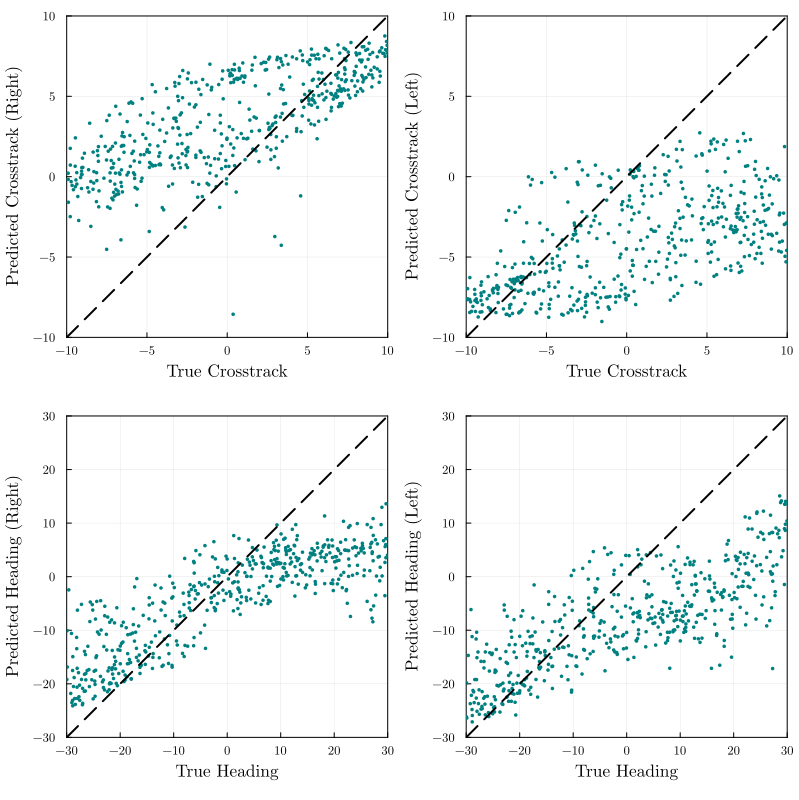

In [158]:
p1 = scatter(true_crosstracks, crosstrack_preds_r, legend=false, xlims=(-10.0, 10.0), ylims=(-10.0, 10.0),
    xlabel="True Crosstrack", ylabel="Predicted Crosstrack (Right)", markercolor=:teal,
    markerstrokecolor=:teal, markersize=2)
plot!(p1, [-10.0, 10.0], [-10.0, 10.0], color=:black, linestyle=:dash, lw=2, aspect_ratio=:equal)

p2 = scatter(true_crosstracks, crosstrack_preds_l, legend=false, xlims=(-10.0, 10.0), ylims=(-10.0, 10.0),
    xlabel="True Crosstrack", ylabel="Predicted Crosstrack (Left)", markercolor=:teal,
    markerstrokecolor=:teal, markersize=2)
plot!(p2, [-10.0, 10.0], [-10.0, 10.0], color=:black, linestyle=:dash, lw=2, aspect_ratio=:equal)

p3 = scatter(true_headings, heading_preds_r, legend=false, xlims=(-30.0, 30.0), ylims=(-30.0, 30.0),
    xlabel="True Heading", ylabel="Predicted Heading (Right)", markercolor=:teal,
    markerstrokecolor=:teal, markersize=2)
plot!(p3, [-30.0, 30.0], [-30.0, 30.0], color=:black, linestyle=:dash, lw=2, aspect_ratio=:equal)

p4 = scatter(true_headings, heading_preds_l, legend=false, xlims=(-30.0, 30.0), ylims=(-30.0, 30.0),
    xlabel="True Heading", ylabel="Predicted Heading (Left)", markercolor=:teal,
    markerstrokecolor=:teal, markersize=2)
plot!(p4, [-30.0, 30.0], [-30.0, 30.0], color=:black, linestyle=:dash, lw=2, aspect_ratio=:equal)

p = plot(p1, p2, p3, p4, layout=(2,2), size=(800,800))

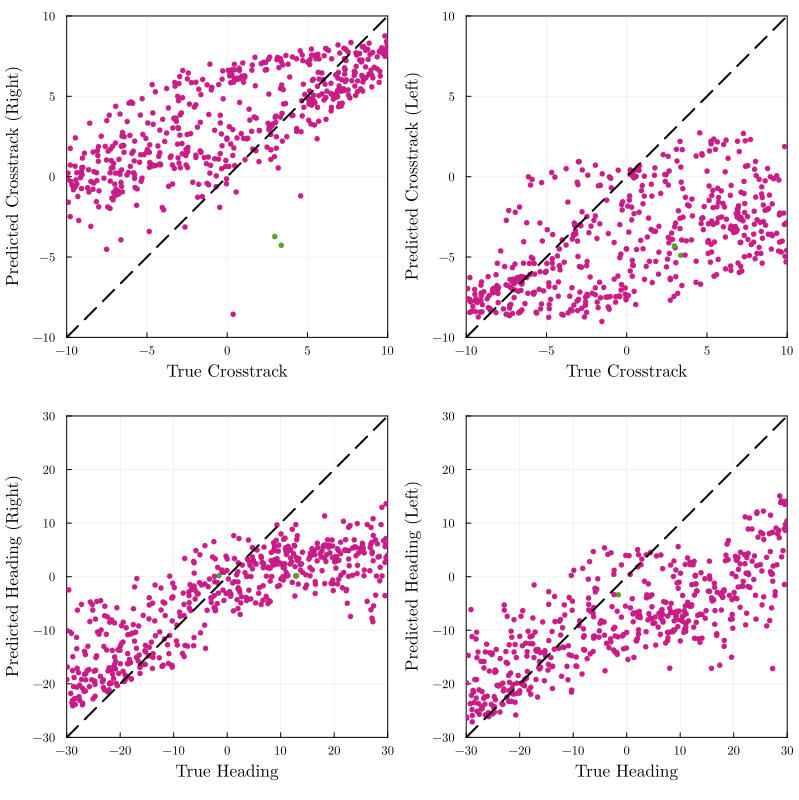

In [159]:
p1 = scatter(true_crosstracks, crosstrack_preds_r, legend=false, xlims=(-10.0, 10.0), ylims=(-10.0, 10.0),
    xlabel="True Crosstrack", ylabel="Predicted Crosstrack (Right)", markersize=3, zcolor=zs, c=:PiYG_4, msw=0)
plot!(p1, [-10.0, 10.0], [-10.0, 10.0], color=:black, linestyle=:dash, lw=2, aspect_ratio=:equal)

p2 = scatter(true_crosstracks, crosstrack_preds_l, legend=false, xlims=(-10.0, 10.0), ylims=(-10.0, 10.0),
    xlabel="True Crosstrack", ylabel="Predicted Crosstrack (Left)", markersize=3, zcolor=zs, c=:PiYG_4, msw=0)
plot!(p2, [-10.0, 10.0], [-10.0, 10.0], color=:black, linestyle=:dash, lw=2, aspect_ratio=:equal)

p3 = scatter(true_headings, heading_preds_r, legend=false, xlims=(-30.0, 30.0), ylims=(-30.0, 30.0),
    xlabel="True Heading", ylabel="Predicted Heading (Right)", markersize=3, zcolor=zs, c=:PiYG_4, msw=0)
plot!(p3, [-30.0, 30.0], [-30.0, 30.0], color=:black, linestyle=:dash, lw=2, aspect_ratio=:equal)

p4 = scatter(true_headings, heading_preds_l, legend=false, xlims=(-30.0, 30.0), ylims=(-30.0, 30.0),
    xlabel="True Heading", ylabel="Predicted Heading (Left)", markersize=3, zcolor=zs, c=:PiYG_4, msw=0)
plot!(p4, [-30.0, 30.0], [-30.0, 30.0], color=:black, linestyle=:dash, lw=2, aspect_ratio=:equal)

p = plot(p1, p2, p3, p4, layout=(2,2), size=(800,800))

In [160]:
ind = 58
println(get_state(labels_valid[3, ind], labels_valid[4, ind], K0, ground_plane_kmwh, u1_kmwh, c1_kmwh, hw_kmwh, right=true))
println((labels_valid[5, ind], labels_valid[6, ind]))

(6.322005890275023, -8.182325747636146)
(7.3537f0, -8.224395f0)


In [83]:
labels_valid[5, 3], labels_valid[6, 3]

(6.903995f0, -27.706991f0)

In [99]:
function get_pixels(m, b, w, h)
    xs = collect(1:w)
    ys = [m * x + b for x in xs]
    keep_inds = (ys .> 0) .& (ys .< h)
    return xs[keep_inds], ys[keep_inds]
end

get_pixels (generic function with 1 method)

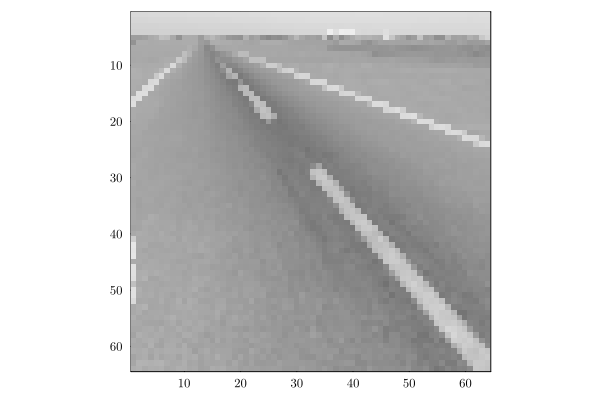

In [100]:
img = X_valid[:, :, 1, 3]
heatmap(Gray.(img'))

In [104]:
h, w = size(img)
xs, ys = get_pixels(labels_valid[3, 3], labels_valid[4, 3], w, h)

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], Float32[15.564825, 14.603578, 13.64233, 12.681082, 11.719833, 10.758586, 9.7973385, 8.83609, 7.8748417, 6.9135942, 5.952347, 4.9910984, 4.02985, 3.0686026, 2.107355, 1.1461067, 0.18485832])

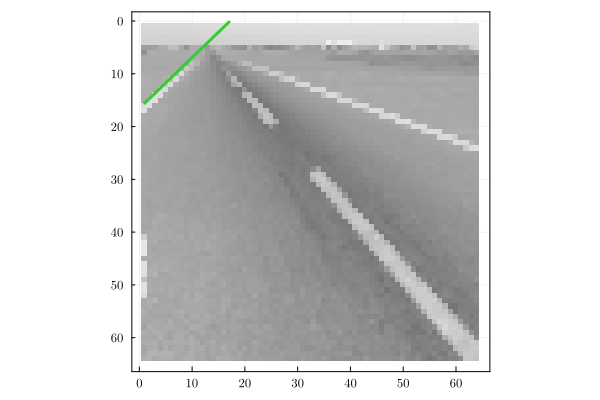

In [105]:
p = heatmap(Gray.(img'))
plot!(p, xs, ys, color=:limegreen, lw=3, legend=false)